[課題のURL](https://diver.diveintocode.jp/curriculums/1876)

# Sprint 深層学習スクラッチ ニューラルネットワーク

In [331]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

* データセットをダウンロード

In [118]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [119]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
#print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)


* 平滑化

In [120]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

* 画像データの可視化

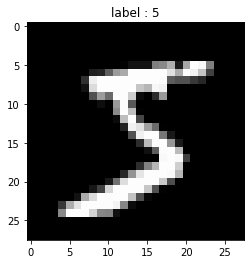

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

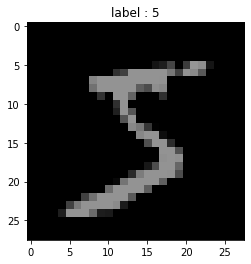

In [6]:
index = 0
image = X_train[index].reshape(28,28)
image = image.astype(np.float) # float型に変換
image -= 105.35 # 意図的に負の小数値を作り出してみる
# plt.imshow(image, 'gray')
plt.imshow(image, 'gray', vmin = 0, vmax = 255)
plt.title('label : {}'.format(y_train[index]))
plt.show()
# print(image) # 値を確認

* 前処理

画像は0から255のuint8型で表されますが、機械学習をする上では0から1のfloat型で扱うことになります。

In [121]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


正解ラベルは0から9の整数ですが、ニューラルネットワークで多クラス分類を行う際には one-hot表現 に変換します。  
scikit-learnのOneHotEncoderを使用したコードが以下です。  
このone-hot表現による値はそのラベルである確率を示していることになるため、float型で扱います。  

In [122]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [9]:
y_train_one_hot.shape

(60000, 10)

In [10]:
y_train_one_hot[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

さらに、訓練データ6万枚の内2割を検証データとして分割してください。  
訓練データが48000枚、検証データが12000枚となります。  

In [123]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape) # (48000, 784)
print(X_val.shape) # (12000, 784)

(48000, 784)
(12000, 784)


In [126]:
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

In [124]:
y_train

array([7, 6, 4, ..., 9, 1, 2], dtype=uint8)

In [125]:
print(y_train_one_hot[0])
print(y_train_one_hot[1])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


# ニューラルネットワークスクラッチ

今回は多クラス分類を行う3層のニューラルネットワークを作成します。

* ミニバッチ処理

ニューラルネットワークではデータを分割して入力する 確率的勾配降下法 が一般的です。  
分割した際のひとかたまりを ミニバッチ 、そのサンプル数を バッチサイズ と呼びます。  

今回はバッチサイズを20とします。  
今回使う訓練データは48000枚ですから、48000÷20で2400回の更新を繰り返すことになります。  
ニューラルネットワークではこれを2400回 イテレーション（iteration） すると呼びます。  
訓練データを一度全て見ると1回の エポック（epoch） が終わったことになります。  
このエポックを複数回繰り返し、学習が完了します。  

これを実現するための簡素なイテレータを用意しました。  
for文で呼び出すと、ミニバッチを取得できます。  

In [15]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [16]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
print(len(get_mini_batch)) # 2400
print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

2400
(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), array([1, 6, 0, 0, 1, 5, 4, 7, 3, 4, 7, 2, 3, 1, 6, 7, 6, 4, 6, 1],
      dtype=uint8))


In [397]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    def __init__(self, epoch = 5, alpha = 0.001, verbose = True):
        self.verbose = verbose
        
        self._epoch = epoch
        self._batch_size = 20 # バッチサイズ
        
        self._n_features = 784 # 特徴量の数
        self._n_nodes1 = 400 # 1層目のノード数
        self._n_nodes2 = 200 # 2層目のノード数
        self._n_output = 10 # 出力のクラス数（3層目のノード数）
        
        self._sigm = 1 # ガウス分布の標準偏差
        self._alpha = alpha
        
    def _get_init_w(self, n_nodes0, n_nodes1, sigma=0.01):
        # sigma # ガウス分布の標準偏差
        np.random.seed(1)
        w = sigma * np.random.randn(n_nodes0, n_nodes1)
    
        return w
        
    def _get_init_b(self, n_nodes, sigma=0.01):
        # sigma # ガウス分布の標準偏差
        np.random.seed(1)
        b = sigma * np.random.randn(n_nodes)

        return b
    
    def _encode_10(self, data):
    
        t = np.zeros((data.size, 10))
        for i in range(data.size):
            t[i, data[i]] = 1

        return t
    
    def _func_activation(self, x):
        sigmoid_range = 34.538776394910684

        x = np.clip(x, -sigmoid_range, sigmoid_range)
        
        return 1.0/(1.0+np.exp(-x))

    def _softmax(self, x):
        # データ数
        n = x.shape[0]

        for i in range(n):
            exp_x = np.exp(x[i])
            sum_exp_x = np.sum(exp_x)
            x[i] = exp_x/sum_exp_x

        return x
    
    def _forward(self, X, w1, w2, w3, b1, b2, b3):
        # 学習データを0層目(入力層)に設定
        l0 = X

        # 1層目
        l1 = self._func_activation(np.dot(l0,w1) + b1 )

        # 2層目
        l2 = self._func_activation(np.dot(l1,w2) + b2 )

        # 3層目(出力層)
        l3 = self._softmax(np.dot(l2,w3) + b3 )

        return l1, l2, l3

    def _func_object(self, y, z):
        # 0割回避のため(z=0を防ぐため)
        delta = 1e-7
        n = y.shape[0]

        l = -1/n*np.sum(y*np.log(z+delta))

        return l

    def _back(self, X, y, w1, w2, w3, b1, b2, b3, l1, l2, l3, alpha = 0.001):
        # 3層目
        l_A3 = l3 - y
        l_w3 = np.dot(l2.T, l_A3)
        l_B3 = np.sum(l_A3, axis=0)

        w3 = w3 - alpha*l_w3
        b3 = b3 - alpha*l_B3

        # 2層目
        l_z2 = np.dot(l_A3, w3.T) # (batch_size, n_nodes2) = (20, 200)

        l_A2 =  l_z2*((1 - self._func_activation(l2))*(self._func_activation(l2))) # (batch_size, n_nodes2) = (20, 200)
        l_w2 = np.dot(l1.T, l_A2) # (n_nodes1, n_nodes2) = (400, 200)
        l_B2 = np.sum(l_A2, axis=0) # (n_nodes2,) = (200, )

        w2 = w2 - alpha*l_w2
        b2 = b2 - alpha*l_B2

        # 1層目
        l_z1 = np.dot(l_A2, w2.T) # (batch_size, n_nodes1) = (20, 400)
        l_A1 = l_z1*((1 - self._func_activation(l1))*(self._func_activation(l1))) # (batch_size, n_nodes1) = (20, 400)
        l_w1 = np.dot(X.T, l_A1) #  (n_features, n_nodes1) = (784, 400)

        l_B1 = np.sum(l_A1, axis=0) # (n_output,) = (400, ), n_outputではなく、n_node1?

        w1 = w1 - alpha*l_w1
        b1 = b1 - alpha*l_B1

        return w1, w2, w3, b1, b2, b3
    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        # 検証データ(X_val, y_val)の有無を確認
        flag_val = True
        if (X_val is None) and (y_val is None):
            # 検証データが入力されなかった場合、検証データの保存と学習過程を表示しない
            flag_val = False
        
        # 内部変数の初期設定(アトリビュート関連)
        batch_size = self._batch_size
        n_features = self._n_features
        n_nodes1 = self._n_nodes1
        n_nodes2 = self._n_nodes2
        n_output = self._n_output
        sigma = self._sigm
        alpha = self._alpha
        epoch = self._epoch
        
        # w,bの初期設定
        w1 = self._get_init_w(n_features, n_nodes1, sigma)
        w2 = self._get_init_w(n_nodes1, n_nodes2, sigma)
        w3 = self._get_init_w(n_nodes2, n_output, sigma)

        b1 = self._get_init_b(n_nodes1, sigma)
        b2 = self._get_init_b(n_nodes2, sigma)
        b3 = self._get_init_b(n_output, sigma)
        
        # 初期化
        score = np.zeros(epoch)
        accuracy = np.zeros(epoch)

        score_val = np.zeros(epoch)
        accuracy_val = np.zeros(epoch)
        
        for count_epoch in range(epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size, seed=epoch)
            
            # 1 epoch
            for mini_X_train, mini_y_train in get_mini_batch:
                l1, l2, l3 = self._forward(mini_X_train, w1, w2, w3, b1, b2, b3)

                mini_y_train_one_hot = self._encode_10(mini_y_train)

                w1, w2, w3, b1, b2, b3 = self._back(mini_X_train, mini_y_train_one_hot, w1, w2, w3, b1, b2, b3, l1, l2, l3, alpha)

            # 学習データの更新
            # predictで利用するので、学習後すぐにパラメータを更新
            self.w = [w1, w2, w3]
            self.b = [b1, b2, b3]

            # エポックごとの損失（交差エントロピー誤差）を記録
            y_pred, y_pred_portion = self.predict(X_train)
            
            # 交差エントロピー誤差
            score[count_epoch] = self._func_object(encode_10(y_train), y_pred_portion)
            
            # 正解率
            accuracy[count_epoch] = accuracy_score(y_pred, y)
            
            if flag_val == True:
                y_pred_val, y_pred_val_portion = self.predict(X_val)
                score_val[count_epoch] = self._func_object(encode_10(y_val), y_pred_val_portion)
                accuracy_val[count_epoch] = accuracy_score(y_pred_val, y_val)

            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                if flag_val == True:
                    print("epoch:",(count_epoch+1),"accuracy:",accuracy[count_epoch], "loss:", score[count_epoch])
                    print("epoch:",(count_epoch+1),"accuracy_val:",accuracy_val[count_epoch], "loss_val:", score_val[count_epoch])
                else:
                    print("epoch:",(count_epoch+1),"accuracy:",accuracy[count_epoch], "loss:", score[count_epoch])
        
            # 学習データの保存
            self._score = score
            self._accuracy = accuracy
            self._score_val = score_val
            self._accuracy_val = accuracy_val
            
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        # w,bの初期設定
        w1 = self.w[0]
        w2 = self.w[1]
        w3 = self.w[2]

        b1 = self.b[0]
        b2 = self.b[1]
        b3 = self.b[2]
        
        l1, l2, l3 = self._forward(X, w1, w2, w3, b1, b2, b3)

        portion = l3
        label = np.argmax(l3, axis = 1)
        
        return label, l3

* 学習  
ニューラルネットワークの学習はフォワードプロパゲーションとバックプロパゲションの繰り返しになります。  

# 【問題1】重みの初期値を決めるコードの作成

ニューラルネットワークの各層の重みの初期値を決めるコードを作成してください。　　

重みの初期値は様々な方法が提案されていますが、今回はガウス分布による単純な初期化を行います。バイアスに関しても同様です。　　

以下のコードを参考にしてください。標準偏差の値sigmaはハイパーパラメータです。発展的な重みの初期化方法については次のSprintで扱います。　　

In [368]:
n_features = 784 # 入力層
n_nodes1 = 400 # 2層(ノード数)
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)

In [139]:
def get_init_w(n_nodes0, n_nodes1, sigma=0.01):
    
    # sigma # ガウス分布の標準偏差
    np.random.seed(1)
    w = sigma * np.random.randn(n_nodes0, n_nodes1)
    
    return w

In [146]:
def get_init_b(n_nodes, sigma=0.01):
    
    np.random.seed(1)
    b = sigma * np.random.randn(n_nodes)
    #b = np.zeros(n_nodes)
    
    return b

# 【問題2】フォワードプロパゲーションの実装

三層のニューラルネットワークの フォワードプロパゲーション を作成してください。  
以下の説明ではノード数は1層目は400、2層目は200としますが、変更しても構いません。  

各層の数式を以下に示します。  
今回はそれぞれの記号が表す配列が、実装上どのようなndarrayのshapeになるかを併記してあります。  

In [21]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）
sigma = 1

In [277]:
# 初期値の設定
w1 = get_init_w(n_features, n_nodes1, sigma)
w2 = get_init_w(n_nodes1, n_nodes2, sigma)
w3 = get_init_w(n_nodes2, n_output, sigma)

b1 = get_init_b(n_nodes1, 0)
b2 = get_init_b(n_nodes2, 0)
b3 = get_init_b(n_output, 0)

In [278]:
print(w1.shape, w2.shape, w3.shape) # (784, 400) (400, 200) (200, 10)
print(b1.shape, b2.shape, b3.shape) # (400,) (200,) (10,)

(784, 400) (400, 200) (200, 10)
(400,) (200,) (10,)


In [51]:
def encode_10(data):
    
    t = np.zeros((data.size, 10))
    for i in range(data.size):
        t[i, data[i]] = 1

    return t

In [395]:
# 活性化関数
def func_activation(x):

    return 1/(1+np.exp(-x))

In [41]:
def softmax(x):
    
    # データ数
    n = x.shape[0]
    
    for i in range(n):
        exp_x = np.exp(x[i])
        sum_exp_x = np.sum(exp_x)
        x[i] = exp_x/sum_exp_x
    
    return x

In [396]:
def forward(X, w1, w2, w3, b1, b2, b3):
    # 学習データを0層目(入力層)に設定
    l0 = X
    
    # 1層目
    l1 = func_activation(np.dot(l0,w1) + b1 )
    
    # 2層目
    l2 = func_activation(np.dot(l1,w2) + b2 )
    
    # 3層目(出力層)
    l3 = func_activation(np.dot(l2,w3) + b3 )
    
    return l1, l2, l3

In [84]:
get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=20)
#print(len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる

i_count = 0

for mini_X_train, mini_y_train in get_mini_batch:
    print(mini_X_train)
    print(mini_y_train)

    forward(mini_X_train, w1, w2, w3, b1, b2, b3)
    
    if i_count == 0:
        break

    i_count = i_count + 1

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1 1 8 0 6 4 0 4 6 1 6 4 8 8 6 0 3 5 0 5]


In [85]:
l0.shape, l1.shape, l2.shape, l3.shape

((20, 784), (20, 400), (20, 200), (20, 10))

# 【問題3】交差エントロピー誤差の実装

目的関数（損失関数）を作成します。

多クラス分類の目的関数である交差エントロピー誤差 Lは次の数式です。

$L = - \frac{1}{n_b}\sum_{j}^{n_b}\sum_{k}^{n_c}y_{jk} log(z_{3\_jk})$

In [199]:
def func_object(y, z):
    
    # 0割回避のため(z=0を防ぐため)
    delta = 1e-7
    
    n = y.shape[0]
    
    l = -1/n*np.sum(y*np.log(z+delta))
    
    return l

# 【問題4】バックプロパゲーションの実装

三層のニューラルネットワークのバックプロパゲーションを作成してください。  
確率的勾配降下法を行う部分です。  

In [141]:
def back(X, y, w1, w2, w3, b1, b2, b3, l1, l2, l3, alpha = 0.001):
    # 3層目
    l_A3 = l3 - y
    l_w3 = np.dot(l2.T, l_A3)
    l_B3 = np.sum(l_A3, axis=0)
    
    w3 = w3 - alpha*l_w3
    b3 = b3 - alpha*l_B3

    # 2層目
    l_z2 = np.dot(l_A3, w3.T) # (batch_size, n_nodes2) = (20, 200)

    l_A2 =  l_z2*((1 - func_activation(l2))*(func_activation(l2))) # (batch_size, n_nodes2) = (20, 200)
    l_w2 = np.dot(l1.T, l_A2) # (n_nodes1, n_nodes2) = (400, 200)
    l_B2 = np.sum(l_A2, axis=0) # (n_nodes2,) = (200, )

    w2 = w2 - alpha*l_w2
    b2 = b2 - alpha*l_B2

    # 1層目
    l_z1 = np.dot(l_A2, w2.T) # (batch_size, n_nodes1) = (20, 400)
    l_A1 = l_z1*((1 - func_activation(l1))*(func_activation(l1))) # (batch_size, n_nodes1) = (20, 400)
    l_w1 = np.dot(X.T, l_A1) #  (n_features, n_nodes1) = (784, 400)

    l_B1 = np.sum(l_A1, axis=0) # (n_output,) = (400, ), n_outputではなく、n_node1?

    w1 = w1 - alpha*l_w1
    b1 = b1 - alpha*l_B1
    
    return w1, w2, w3, b1, b2, b3

# 【問題5】推定

推定を行うメソッドを作成してください。  

フォワードプロパゲーションによって出力された10個の確率の中で、最も高いものはどれかを判定します。  

In [203]:
def predict(X, w1, w2, w3, b1, b2, b3):

    l1, l2, l3 = forward(X, w1, w2, w3, b1, b2, b3)
    
    portion = l3
    label = np.argmax(l3, axis = 1)

    return label, l3

# 【問題6】学習と推定

MNISTのデータを学習・推定し、Accuracyを計算してください  

In [400]:
clf_sc = ScratchSimpleNeuralNetrowkClassifier(epoch=100, alpha = 0.001, verbose = True)
clf_sc.fit(X_train, y_train, X_val, y_val)

epoch: 1 accuracy: 0.8427291666666666 loss: 0.7904242189263262
epoch: 1 accuracy_val: 0.84275 loss_val: 0.8102345997627595
epoch: 2 accuracy: 0.8729791666666666 loss: 0.6524063267639377
epoch: 2 accuracy_val: 0.8668333333333333 loss_val: 0.6697784553376345
epoch: 3 accuracy: 0.884 loss: 0.5909660459363885
epoch: 3 accuracy_val: 0.8816666666666667 loss_val: 0.6127439537775116
epoch: 4 accuracy: 0.8925208333333333 loss: 0.5146228151884149
epoch: 4 accuracy_val: 0.8889166666666667 loss_val: 0.5370754399193296
epoch: 5 accuracy: 0.8984791666666667 loss: 0.4646309178711798
epoch: 5 accuracy_val: 0.8938333333333334 loss_val: 0.48269209193007295
epoch: 6 accuracy: 0.9040833333333333 loss: 0.44471400951821743
epoch: 6 accuracy_val: 0.8975833333333333 loss_val: 0.4635369250790023
epoch: 7 accuracy: 0.9076041666666667 loss: 0.41918883941422164
epoch: 7 accuracy_val: 0.9019166666666667 loss_val: 0.43934057289384054
epoch: 8 accuracy: 0.9094166666666667 loss: 0.4051314739954192
epoch: 8 accuracy_v

In [403]:
y_pred, y_pred_portion = clf_sc.predict(X_test)

print("Accuracy（正解率）", accuracy_score(y_test, y_pred))

Accuracy（正解率） 0.9455


# 【問題7】学習曲線のプロット

学習曲線をプロットしてください。  

ニューラルネットワークは過学習が発生しやすいため、学習曲線の確認が重要です。  
訓練データと検証データに対するエポックごとの損失（交差エントロピー誤差）を記録できるようにする必要があります。  

オレンジ:X_val, 青:X_train


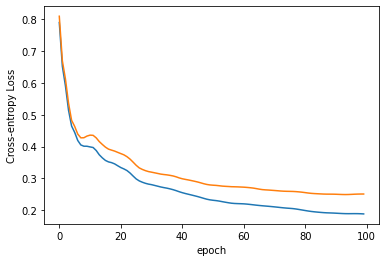

In [407]:
plt.plot(clf_sc._score)
plt.plot(clf_sc._score_val)

plt.xlabel("epoch")
plt.ylabel("Cross-entropy Loss")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()

オレンジ:X_val, 青:X_train


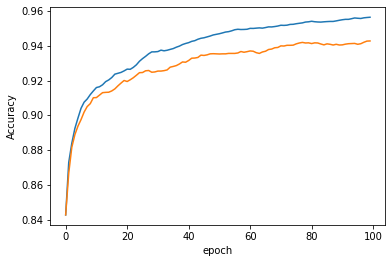

In [408]:
plt.plot(clf_sc._accuracy)
plt.plot(clf_sc._accuracy_val)

plt.xlabel("epoch")
plt.ylabel("Accuracy")

# Visualize
print("オレンジ:X_val, 青:X_train")
plt.show()